In [1]:
using DynamicalSystems, DifferentialEquations, OrdinaryDiffEq, StaticArrays, Statistics, JLD

In [2]:
function sigma(x)
    return 1.0 / ( 1.0 + exp( -10.0 * ( x  - ( - 0.25 ) ) ) )
end

function HR(u, p, t)
        
    a, b, c, d, s, xr, r,  I, vs, k1, k2, el_link  = p
    x1, y1, z1, x2, y2, z2 = u
    
    du1 = y1 + b * x1 ^ 2 - a * x1 ^3 - z1 + I - k1 * ( x1 - vs ) * sigma(x2) + el_link * ( x2 - x1 )
    du2 = c - d * x1 ^2 - y1
    du3 = r * ( s * ( x1 - xr ) - z1 )
    
    du4 = y2 + b * x2 ^ 2 - a * x2 ^3 - z2 + I - k2 * ( x2 - vs ) * sigma(x1) + el_link * ( x1 - x2 )
    du5 = c - d * x2 ^2 - y2
    du6 = r * ( s * ( x2 - xr ) - z2 )
    
    return SVector(du1, du2, du3,
                    du4, du5, du6)
end

HR (generic function with 1 method)

In [3]:
function CALCPDF(spikes)
    ϵ = 0.9
    ee_counter = [sum(i->s<=i<s+ϵ, spikes) for s in range(0,4,5000000)]
    pdf = ee_counter ./ length(spikes)
    return range(0,4,5000000), pdf
end

CALCPDF (generic function with 1 method)

In [24]:
a = 1.0; b = 3.0; c = 1.0; d = 5.0
xr = -1.6; r = 0.01; s = 5.0; I = 4.0; xv = 2.0
k1= -0.17; k2 = -0.17
k = 0.0
tspan = (0.0, 6000.0)

(0.0, 6000.0)

In [25]:
length(range(tspan[1], tspan[2], step = 0.001))

6000001

In [26]:
k_space = range(0.0, 1.0, step = 0.0002)

0.0:0.0002:1.0

In [27]:
spectrum_array = zeros(6, length(k_space))
condition_array = zeros(6, length(k_space))

EVA_array = zeros(length(k_space))

int(x) = floor(Int, x)
length(k_space)

5001

In [28]:
diffeq_ = (alg = AutoVern9(Rodas5()), adaptive = false, dt = 0.001);

In [29]:
p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
println(p)

[1.0, 3.0, 1.0, 5.0, 5.0, -1.6, 0.01, 4.0, 2.0, -0.17, -0.17, 0.0]


In [37]:
function output_info(index_i, name_p, p, params, u0)
    println("index i: $index_i");flush(stdout)
    println(name_p, ": $k"); flush(stdout)
    println("Initial condition: $u0"); flush(stdout)
    println("p: $p");flush(stdout)
end
function output_separator()
    println("_________________________")
    println("")
end

function Tr(x, drop_size = 2)
    println("variable before truncate length: ", length(x)); flush(stdout)
    x = x[floor(Int, length(x) / drop_size):end ]
    println("variable  after truncate length: ", length(x)); flush(stdout)
    return x
end
Hs(x) = Statistics.mean(x) + 6 * Statistics.std(x)
function calc_number_EEs(x)
    threshold = Hs(x)
    counts = length(x[x.>=threshold])
    return counts
end

calc_number_EEs (generic function with 2 methods)

In [39]:
for (i, k) in enumerate(k_space)
    
    if i == 1
        global u0 =  SA[-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
    end
    
    condition_array[:, i] = u0
    p = SA[a, b, c, d, s, xr, r, I, xv, k1, k2, k]
    
    output_info(i, "k", k, p, u0)
    
    prob = ODEProblem(HR, u0, tspan, p)
    sol = solve(prob, AutoVern9(Rodas5()), adaptive = false, dt = 0.001)
   
    ds_HR = ContinuousDynamicalSystem(HR, u0, p )
    spectrum = lyapunovspectrum(ds_HR, tspan[2]; diffeq = diffeq_)
    spectrum_array[1:6, i] = spectrum[1:6]
    println("Spectrum: ", spectrum_array[1:6, i]); flush(stdout)
    
    u0 = sol[end]
    
    println("Last point: ", u0); flush(stdout)
    
    xsum = sol[1,:] + sol[4,:]
    xsum = Tr(xsum)
    
    numbers_EEs = calc_number_EEs(xsum)
    EVA_array[i]  = numbers_EEs
    
    println("numbers_EEs: ", numbers_EEs)
    output_separator()
end

index i: 1
k: 0.0
Initial condition: [-1.5, 0.0, 0.0, -2.5, 0.0, 0.0]
p: 0.0
Spectrum: [0.01328606683391588, 0.006919797434288015, -0.0003051860438477524, -0.03079616996686041, -6.315415656354595, -11.576553677394253]
Last point: [-1.431439812569028, -8.805570829014597, 3.7196179793523036, 1.074052499498027, -0.3348314406972839, 4.063488505895476]
variable before truncate length: 6000001
variable  after truncate length: 3000002
numbers_EEs: 0
_________________________

index i: 2
k: 0.0
Initial condition: [-1.431439812569028, -8.805570829014597, 3.7196179793523036, 1.074052499498027, -0.3348314406972839, 4.063488505895476]
p: 0.0002
Spectrum: [0.013521797214613175, 0.007011041614726716, -0.0002902448629298822, -0.030802946546506435, -6.394591019347526, -11.601331105847171]
Last point: [-0.946697462874138, -3.461223646913957, 4.077184526527263, -1.0050195382479887, -4.541455245573206, 3.449630081851054]
variable before truncate length: 6000001
variable  after truncate length: 3000002
nu

LoadError: InterruptException:

In [23]:
directory = pwd()
filename1 = "\\spectrum_matrix_k1k2_0.17.jld"
filename2 = "\\condition_matrix_k1k2_0.17.jld"
filename3 = "\\EE_array_k1k2_0.17.jld";

In [24]:
save(directory * filename1, "data", spectrum_array)

In [25]:
save(directory * filename2, "data", condition_array)

In [26]:
save(directory * filename3, "data", EVA_array)

In [45]:
directory

"C:\\Users\\olenin.s\\Desktop\\dynamical-systems\\Hindmarrh Rose\\probablity density function"

In [16]:
using CairoMakie

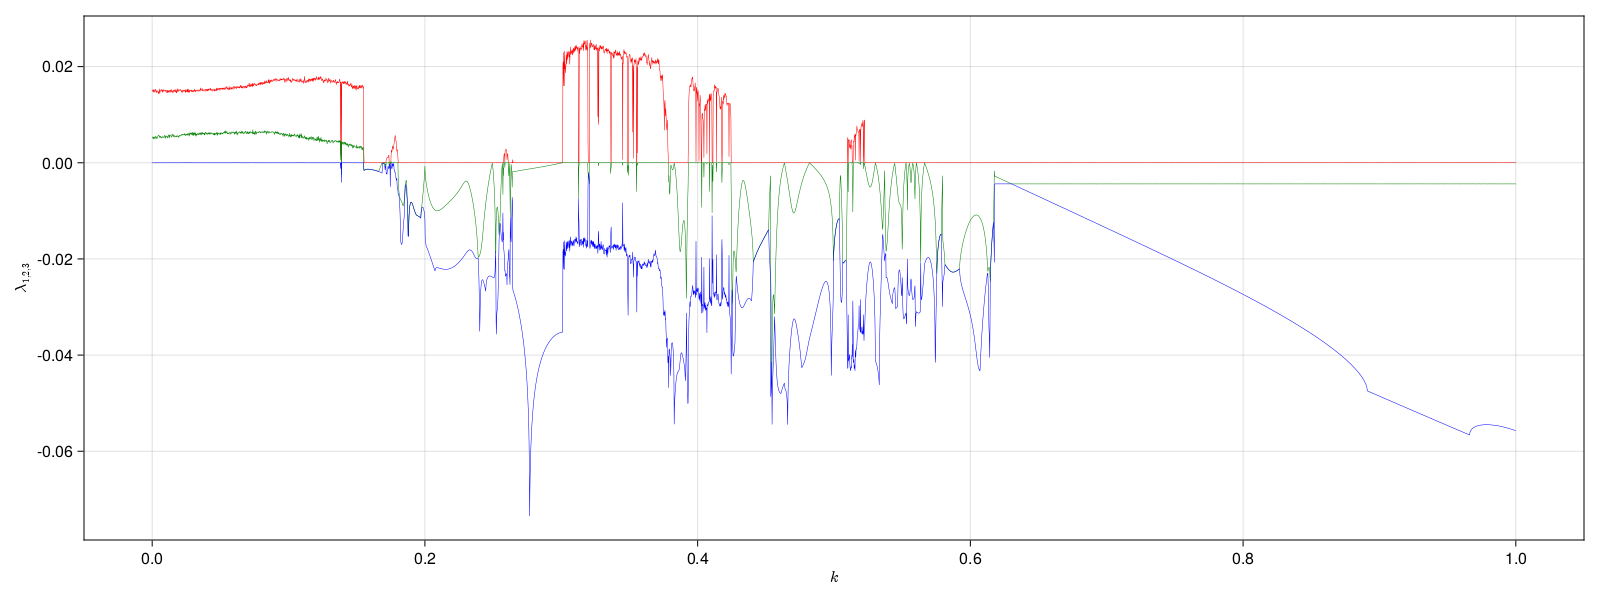

In [27]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, spectrum_array[1, :], linewidth = 0.5, color = "red")
lines!(ax, k_space, spectrum_array[2, :], linewidth = 0.5, color = "green")
lines!(ax, k_space, spectrum_array[3, :], linewidth = 0.5, color = "blue")
f

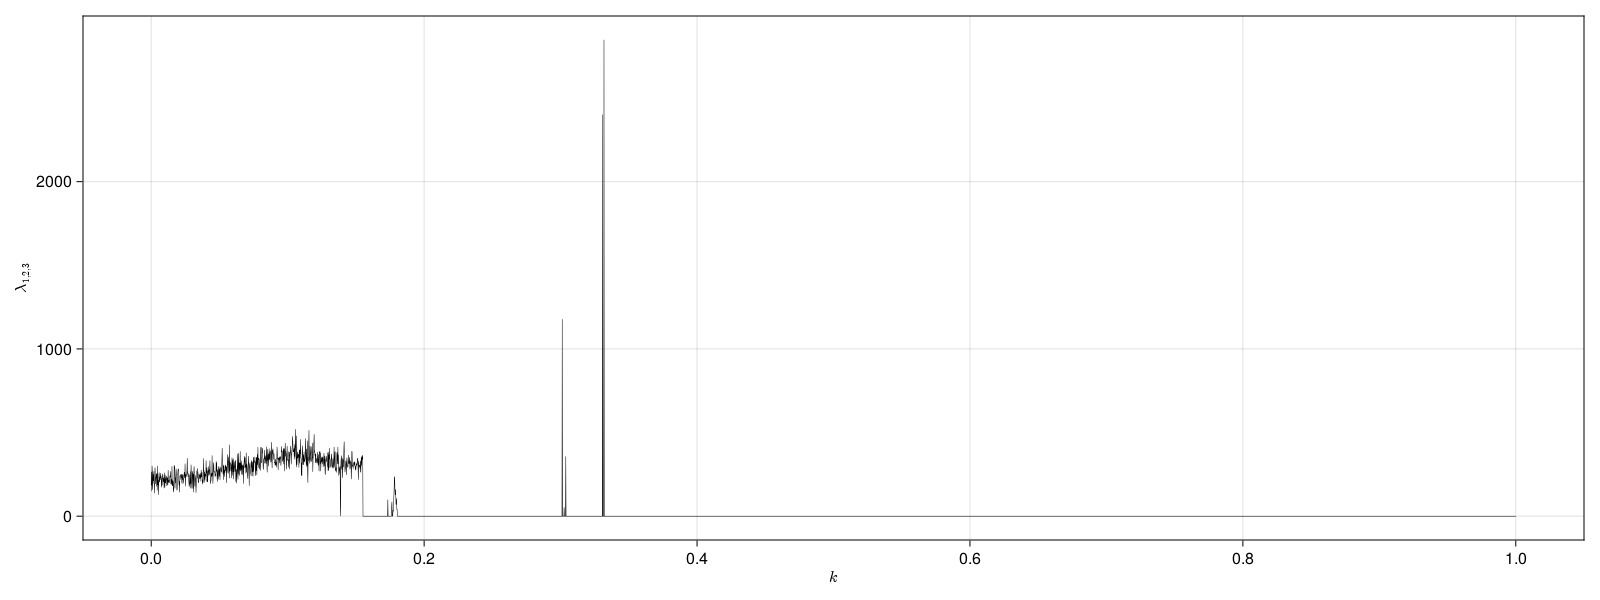

In [28]:
f = Figure(resolution = (1600, 600) )
ax = Axis(f[1, 1], xlabel = L"k", ylabel = L"\lambda_{1, 2, 3}")
limits = range(0.0, 1.0, step = 0.2)
ax.xticks = limits
lines!(ax, k_space, EVA_array, linewidth = 0.5, color = "black")

f